In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Load preprocessed encoded and scaled data

In [2]:
X_train_scaled = pd.read_csv("X_train_scaled.csv")
X_test_scaled = pd.read_csv("X_test_scaled.csv")
y_train_enc = pd.read_csv("y_train_enc.csv")
y_test_enc = pd.read_csv("y_test_enc.csv")

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
random_forest = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)

# Fit the model on the training data
random_forest.fit(X_train_scaled, y_train_enc)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=20, random_state=42)

In [5]:
# Generate predictions on the (scaled) test data
y_pred = random_forest.predict(X_test_scaled)

# Evaluate the model
report = classification_report(y_test_enc, y_pred)
matrix = confusion_matrix(y_test_enc, y_pred)

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))

Accuracy: 0.6361290322580645

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.74      0.69      1355
           1       0.52      0.42      0.46      1583
           2       0.71      0.76      0.73      1712

    accuracy                           0.64      4650
   macro avg       0.62      0.64      0.63      4650
weighted avg       0.63      0.64      0.63      4650


Confusion Matrix:
 [[ 996  275   84]
 [ 472  658  453]
 [  80  328 1304]]


<Axes: >

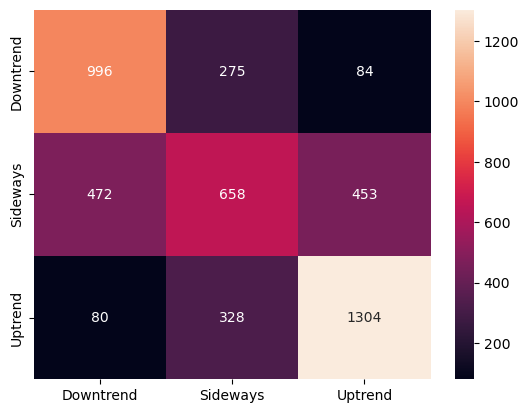

In [6]:
sns.heatmap(matrix, annot=True, fmt="g", xticklabels=['Downtrend', 'Sideways', 'Uptrend'],
            yticklabels=['Downtrend', 'Sideways', 'Uptrend'])

**Insight**

**1.** Downtrend (0)

Precision: 0.67, Recall: 0.74
Strong class similar to logistic regression.

**2.** Sideways (1)

Precision: 0.53, Recall: 0.46
Sideways continues to be difficult (noise, overlapping patterns).

**3.** Uptrend (2)

Precision: 0.72, Recall: 0.74
Very consistent and strong.

**In summary**

Uptrend continues to be your strongest class across models, followed by Downtrend, then Sideways.

## Hyperparameter Tunning

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
}


# Grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=2
)

In [9]:
grid_search.fit(X_train_scaled, y_train_enc)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [10]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.6254941736946882


#### Select best parameters based on accuracy

Best Random Forest Test Accuracy: 0.6455913978494624

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70      1355
           1       0.53      0.46      0.49      1583
           2       0.72      0.74      0.73      1712

    accuracy                           0.65      4650
   macro avg       0.64      0.65      0.64      4650
weighted avg       0.64      0.65      0.64      4650



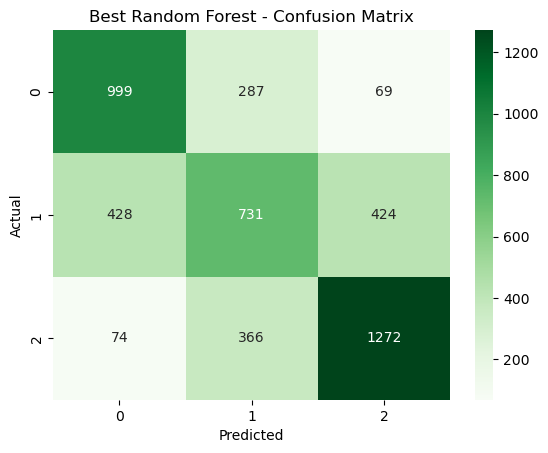

In [11]:
# Get best model
best_rf = grid_search.best_estimator_

# Evaluate on test data
y_pred_rf_best = best_rf.predict(X_test_scaled)

acc_rf_best = accuracy_score(y_test_enc, y_pred_rf_best)
report_rf_best = classification_report(y_test_enc, y_pred_rf_best)
matrix_rf_best = confusion_matrix(y_test_enc, y_pred_rf_best)

print("Best Random Forest Test Accuracy:", acc_rf_best)
print("\nClassification Report:\n", report_rf_best)

sns.heatmap(matrix_rf_best, annot=True, fmt='d', cmap='Greens')
plt.title("Best Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Insight**

Accuracy remains consistently around 64–65% 

**Uptrend prediction** is the strongest (high recall, high precision)

This means uptrends have clean signals.

**Sideways** is the hardest (market noise + lack of trend)



**Random Forest** performs similarly to **Logistic Regression**

This means data is not heavily nonlinear, OR Lags + technical indicators already capture most dynamics


**RandomForest** slight increase in accuracy after **tuning RF** this shows hyperparameter tuning was useful.

The 1-row drop in baseline notebook due to NaN removal after lag + encoding steps.

#### Compare Random Forest vs Logistic Regression performance

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
# Logistic Regression for comparison
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_enc)
y_pred_lr = logreg.predict(X_test_scaled)

acc_lr = accuracy_score(y_test_enc, y_pred_lr)
f1_lr = classification_report(y_test_enc, y_pred_lr, output_dict=True)['weighted avg']['f1-score']
f1_rf = classification_report(y_test_enc, y_pred_rf_best, output_dict=True)['weighted avg']['f1-score']

# Comparison table
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest (Tuned)'],
    'Accuracy': [acc_lr, acc_rf_best],
    'Weighted F1': [f1_lr, f1_rf]
})

print("\nPerformance Comparison:")
display(comparison)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Performance Comparison:


,Model,Accuracy,Weighted F1
0,Logistic Regression,0.651613,0.649967
1,Random Forest (Tuned),0.645591,0.640983


#### Save best model

In [14]:
from joblib import dump

dump(best_rf, "random_forest_model.pkl")

print("Model saved successfully as random_forest_model.pkl")

Model saved successfully as random_forest_model.pkl


#### Analyse prediction errors (which stocks/periods are hardest to predict)

In [15]:
# Add predictions for error analysis
error_df = X_test_scaled.copy()
error_df['true_label'] = y_test_enc
error_df['pred_label'] = y_pred_rf_best
error_df['correct'] = (error_df['true_label'] == error_df['pred_label']).astype(int)

# Misclassified examples
errors = error_df[error_df['correct'] == 0]
print("Total misclassified samples:", len(errors))

# Per-class accuracy
class_accuracy = (
    error_df.groupby('true_label')['correct'].mean()
    .rename('accuracy')
    .reset_index()
)
print("\nClass-level accuracy:\n", class_accuracy)


Total misclassified samples: 1648

Class-level accuracy:
    true_label  accuracy
0           0  0.737269
1           1  0.461781
2           2  0.742991


## Feature Important

In [16]:
# Extract feature importance from the trained best Random Forest model
importances = best_rf.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(
    by='importance', ascending=False
)

feature_importance_df.head(10)

,feature,importance
26,trend_lag1_Uptrend,0.328891
25,trend_lag1_Sideways,0.113713
28,trend_lag2_Uptrend,0.079641
30,trend_lag3_Uptrend,0.048425
0,momentum_10,0.041132
1,momentum_20,0.036692
9,volume_ratio,0.036369
3,sma_200,0.035622
2,sma_20,0.035049
8,volume_sma_20,0.034217


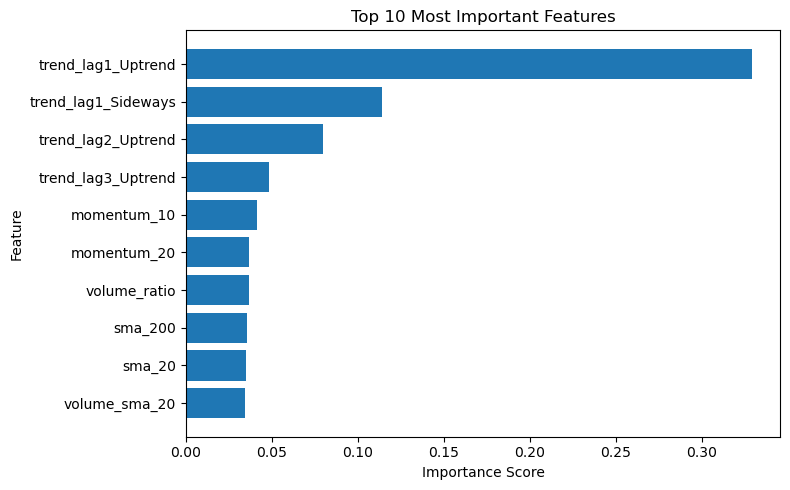

In [19]:
top10 = feature_importance_df.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top10['feature'], top10['importance'])
plt.gca().invert_yaxis()  # Highest at top
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Insight:**

The model’s decisions are mainly driven by how the market has behaved in the last few periods. Yesterday’s trend (Uptrend or Sideways) is by far the strongest predictor of today’s trend, indicating that regimes tend to persist. Additional information from 2–3 bars back further supports this persistence.”

“Momentum over 10 and 20 periods plays a secondary but important role, helping the model distinguish strong sustained moves from weaker, noisy ones.”

“Finally, long- and short-term moving averages and volume-related features provide structural context — they help the model decide whether a movement is aligned with the larger trend and whether it is supported by meaningful trading activity.”

“This behavior is consistent with many trend-following trading strategies, which rely on recent price direction, momentum, and volume to identify and stay in trending markets.

In [20]:
!pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 5.6 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



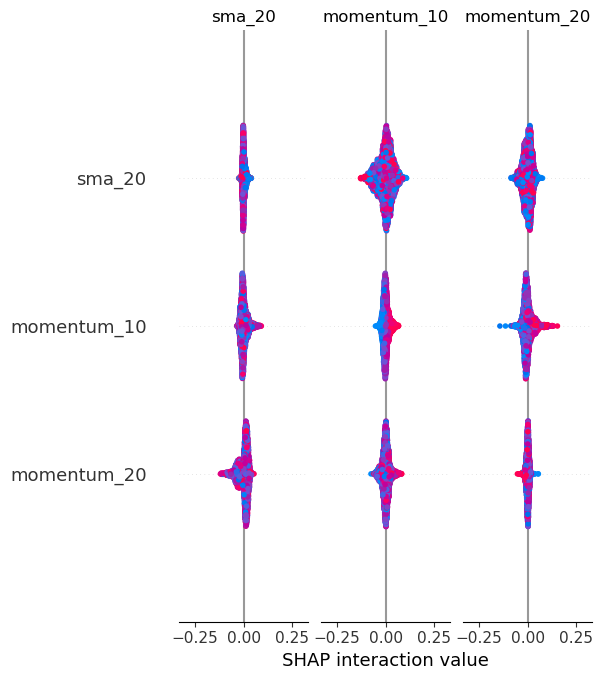

In [21]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled)

**Insight:**

The **20-day moving average** is the most influential feature in the model.
When combined with other indicators, it consistently shifts predictions toward detecting **uptrends or downtrends**.
**Short-term and medium-term momentum indicators** also contribute, but their impact is **smaller and more stable**.
This means the model places more trust in broad trend indicators (like SMA) and less in short-lived momentum spikes.